In [18]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

from helper_functions import plot_decision_boundary

In [19]:
EXAMPLES_PER_CLASS = 100
USELESS_FEATURES = 1

train_data = []
train_labels = []

for _ in range(EXAMPLES_PER_CLASS):
    train_data.append([0., 0., np.random.random()])
    train_labels.append(0.)

    train_data.append([0., 1., np.random.random()])
    train_labels.append(1.)

    train_data.append([1., 0., np.random.random()])
    train_labels.append(1.)

    train_data.append([1., 1., np.random.random()])
    train_labels.append(0.)

train_data, train_labels = torch.tensor(train_data), torch.tensor(train_labels)

test_data = []
test_labels = []

for _ in range(EXAMPLES_PER_CLASS//5):
    test_data.append([0., 0., np.random.random()])
    test_labels.append(0.)

    test_data.append([0., 1., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 0., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 1., np.random.random()])
    test_labels.append(0.)

test_data, test_labels = torch.tensor(test_data), torch.tensor(test_labels)

In [20]:
torch.manual_seed(0)
hidden = 10
model = nn.Sequential(
    nn.Linear(2+USELESS_FEATURES, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [21]:
epochs = 1000
for epoch in range(epochs):
    y_logits = model(train_data).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    if epoch % (epochs//10) == 0:
        with torch.inference_mode():
            y_logits = model(test_data).squeeze()
            y_preds = torch.round(torch.sigmoid(y_logits))
            acc = accuracy_fn(test_labels, y_preds)
            print(f"[EPOCH {epoch+1}/{epochs}] Loss: {loss} | Accuracy: {acc}")


y_logits = model(test_data).squeeze()
y_preds = torch.round(torch.sigmoid(y_logits))
acc = accuracy_fn(test_labels, y_preds)
print(f"[FINAL] Accuracy: {acc}")

[EPOCH 1/1000] Loss: 0.7001405358314514 | Accuracy: 50.0
[EPOCH 101/1000] Loss: 0.645521342754364 | Accuracy: 71.25
[EPOCH 201/1000] Loss: 0.5563161373138428 | Accuracy: 75.0
[EPOCH 301/1000] Loss: 0.42616522312164307 | Accuracy: 100.0
[EPOCH 401/1000] Loss: 0.24454759061336517 | Accuracy: 100.0
[EPOCH 501/1000] Loss: 0.1298755407333374 | Accuracy: 100.0
[EPOCH 601/1000] Loss: 0.07739407569169998 | Accuracy: 100.0
[EPOCH 701/1000] Loss: 0.05152051895856857 | Accuracy: 100.0
[EPOCH 801/1000] Loss: 0.037110112607479095 | Accuracy: 100.0
[EPOCH 901/1000] Loss: 0.028281893581151962 | Accuracy: 100.0
[FINAL] Accuracy: 100.0


In [23]:
#plt.figure(figsize=(4, 4))
#plt.title("XOR with useless feature")
#plot_decision_boundary(model, test_data, test_labels)

In [24]:
X = test_data.detach().numpy()
T = test_labels.detach().numpy()

In [25]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)
L, W[0].shape, W[1].shape

(2, (3, 10), (10, 1))

In [27]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [28]:
i = np.random.randint(0, len(X))
prediction = A[L][i]
print(f"Point: {X[i]}, Pred: {1 if prediction>0 else 0} | Label: {T[i]}")

Point: [1.         1.         0.33819804], Pred: 0 | Label: 0.0


In [29]:
nb_labels = len(np.unique(T))
#R = [None] * L + [A[L] * (T[:,None]==np.arange(nb_labels))]
R = [None] * L + [A[L]]

In [30]:
def rho(w, _l):
    return w
def incr(z, _l):
    return z

In [31]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

In [32]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

In [33]:
R[0].shape, R[1].shape, R[2].shape

((80, 3), (80, 10), (80, 1))

In [35]:
for i in range(8):
    print(f"P: {X[i].tolist()} | Label: {X[i]} | Relevance: {R[0][i]}")

P: [0.0, 0.0, 0.7567811012268066] | Label: [0.        0.        0.7567811] | Relevance: [0. 0. 0.]
P: [0.0, 1.0, 0.9881517887115479] | Label: [0.        1.        0.9881518] | Relevance: [1.1517795 1.5257747 0.7770969]
P: [1.0, 0.0, 0.2584019601345062] | Label: [1.         0.         0.25840196] | Relevance: [1.0615624 0.3919829 0.5874108]
P: [1.0, 1.0, 0.3381980359554291] | Label: [1.         1.         0.33819804] | Relevance: [0. 0. 0.]
P: [0.0, 0.0, 0.8513728380203247] | Label: [0.         0.         0.85137284] | Relevance: [0. 0. 0.]
P: [0.0, 1.0, 0.04518216475844383] | Label: [0.         1.         0.04518216] | Relevance: [1.0220244 1.5167449 0.269252 ]
P: [1.0, 0.0, 0.056639526039361954] | Label: [1.         0.         0.05663953] | Relevance: [1.0382166  0.38278744 0.47748598]
P: [1.0, 1.0, 0.2684342861175537] | Label: [1.        1.        0.2684343] | Relevance: [0. 0. 0.]


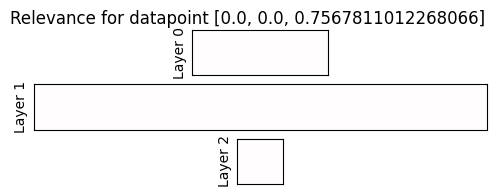

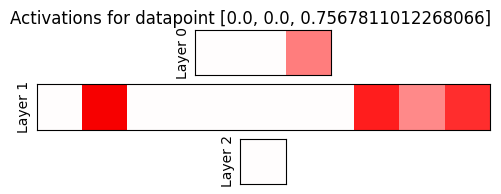

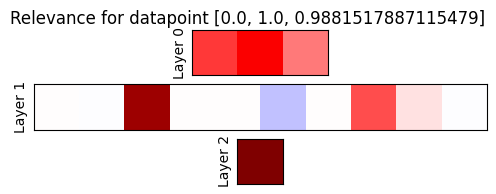

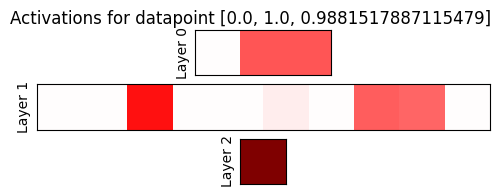

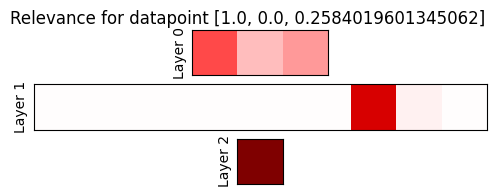

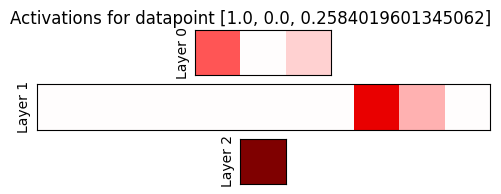

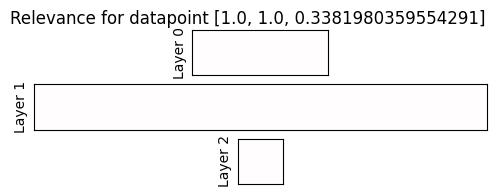

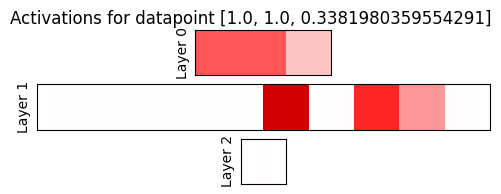

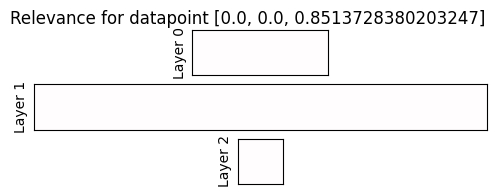

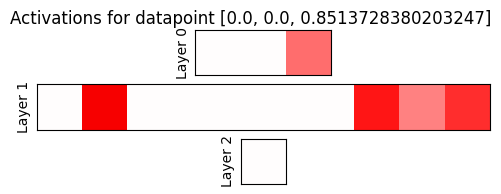

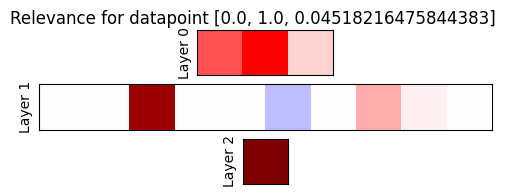

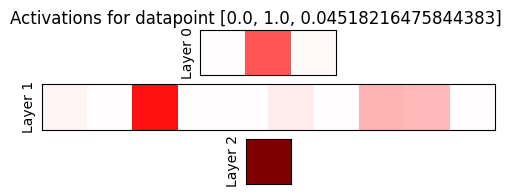

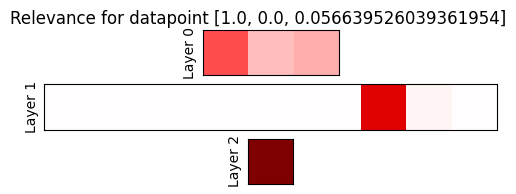

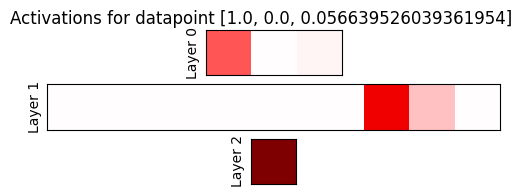

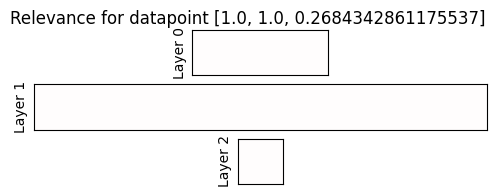

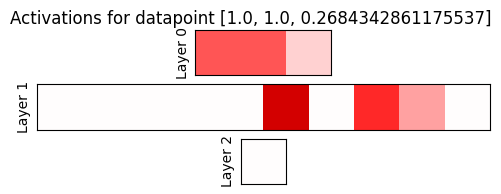

In [36]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

for i in range(8):
    #print(f"[POINT] {data[i].tolist()}")

    # -- Display relevance --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(R[l][i].reshape((1, len(R[l][i]))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        #print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Relevance for datapoint {X[i].tolist()}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(A[l][i].reshape((1, len(A[l][i]))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        #print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Activations for datapoint {X[i].tolist()}")
    plt.show()